# Predicting House Sale Prices



## Data
We'll work with the Ames Housing data set, from 2006 to 2010. The origianal paper with the data can be [found here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627) and the [data dictionary is here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

## Goal




Let's start by setting up a pipeline of functions that will let us quickly iterate on different models.


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold



import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# read in data

df = pd.read_csv('AmesHousing.tsv', delimiter='\t')

In [3]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [4]:
df.shape[0]

2930

In [44]:
def transform_features(df):
    '''
    This functions first removes features we don't want to use 
    in the model, because of missing values or data leakage. 
    
    It then transforms the features into the proper format, 
    such as numerical to categorial, scaling numerical, and 
    filling in missing values. 
    
    Finally, it creates new features by combining other features
    '''
    
    # remove any column with more than 5% missing values
    
    df_null_counts = df.isnull().sum()
    
    df_length = df.shape[0]
    
    # Filter Series to columns containing >5% missing values
    drop_missing_cols = df_null_counts[(df_null_counts > df_length/20)].sort_values()

    # Drop those columns from the data frame. Note the use of the .index accessor
    df_fewer_missing = df.drop(drop_missing_cols.index, axis=1)

    # for numerical columsn missing fewer than 5% of values
    # fill in with the mode
    
    numerical_cols = df_fewer_missing.select_dtypes(include=['int','float']).columns
    #print(numerical_cols)
    for col in numerical_cols:
        if df_null_counts[col] < (0.05 * df_length):
            df_fewer_missing[col].fillna(df_fewer_missing[col].mode(),inplace=True) 
    
    # create two new columns that are more descriptive
    years_sold = df_fewer_missing['Yr Sold'] - df_fewer_missing['Year Built']
    years_since_remod = df_fewer_missing['Yr Sold'] - df_fewer_missing['Year Remod/Add']
    df_fewer_missing['Years Before Sale'] = years_sold
    df_fewer_missing['Years Since Remod'] = years_since_remod
    
    # Drop rows with negative values for both of these new features
    df_fewer_missing = df_fewer_missing.drop([1702, 2180, 2181], axis=0)

    # drop columns that aren't useful 
    # and those that leak info about the sale
    df_fewer_missing = df.drop(["PID", "Order", "Mo Sold", 
                                "Sale Condition", "Sale Type", "Year Built", "Year Remod/Add",
                               'Mas Vnr Area','BsmtFin SF 1','Total Bsmt SF','Garage Yr Blt'], axis=1)
    
    return df_fewer_missing

In [10]:
transform_df = transform_features(df)
transform_df.head()
#df.shape


,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,11160,Pave,Reg,Lvl,AllPub,Corner,...,0,0,0,0,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,13830,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,3,2010,WD,Normal,189900


In [38]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    
    # drop the following columns if they are in the df
    drop_columns = ['Garage Cars', 'TotRms AbvGrd', 'Garage Area']
    df_columns = df.columns.tolist()
    for col in drop_columns:
        if col in df_columns:
            df.drop(col,axis=1,inplace=True)

    # select only the numerical dtypes
    # if the correlation coefficient is less than the threshhold
    # drop those columns
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    
    # deal with the nominal features
    # only keep those with more than the threshhold
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df


In [12]:
#test_df = select_features(df)
#test_df.head()


In [45]:
def train_and_test(df, k=0):
    '''
    df = pandas dataframe
    k = integer for cross validation
    '''
    
    if k == 0:
        # holdout validation
        # split into train and test dfs
        train = df[:1460]
        test = df[1460:]
    
        # train linear regression model using all numerical columns 
        # except SalePrice
    
        numeric_train = train.select_dtypes(include=['float','int'])
    
        features = numeric_train.columns.drop("SalePrice")


        lr = LinearRegression()
        print(features)

        lr.fit(train[features],train['SalePrice'])
    
        predictions = lr.predict(test[features])
    
        mse = mean_squared_error(test['SalePrice'],predictions)
        rmse = np.sqrt(mse)
    
        return rmse
    
    if k > 0:
        # cross validation 
        lr = LinearRegression()
        kf = KFold(n_splits = k, shuffle=True,random_state=1)

        numeric_train = df.select_dtypes(include=['float','int'])
        features = numeric_train.columns.drop("SalePrice")

        
        mses = cross_val_score(lr,
                              df[features],
                              df['SalePrice'],
                              scoring = 'neg_mean_squared_error',
                              cv=kf)
        
        rmse = np.sqrt(np.absolute(np.mean(mses)))
        return(rmse)
    

    

In [14]:
#df.dtypes

In [46]:
transform_df = transform_features(df)

filtered_df = select_features(transform_df)

rmse = train_and_test(filtered_df, k=4)

print(rmse)


39054.39503852947


## Feature Selection

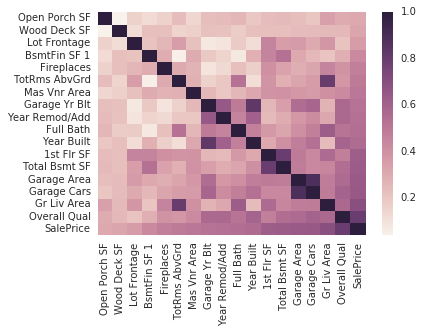

In [43]:
numerical_cols = df.select_dtypes(include=['int','float'])

correlations = numerical_cols.corr()

sorted_corrs = correlations['SalePrice'].abs().sort_values()

strong_corrs = sorted_corrs[sorted_corrs > 0.3]

corrmat = numerical_cols[strong_corrs.index].corr()

sns.heatmap(corrmat)


There is a stronger correlation between two sets of columns:

- Garage Area and Garage Cars
- Gr Living Area and TotRms AbvGrd

These columns reflect similar information about the houses. Because Gr Liv Area and Garage Area are continuous variables that capture more nuance, let's drop the TotRms AbvGrd and Garage Cars. We'll modify ```Select_Features``` to drop these columns.
